In [1]:
from time import sleep
from kafka3 import KafkaConsumer
from datetime import datetime as dt
import matplotlib.pyplot as plt
import json
from pymongo import MongoClient
host_ip = "192.168.1.105"

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nne5bco2 because the default path (/home/student/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
topic = 'Lastest_Climate' #listen to the cliamte report topic


In [3]:
%matplotlib notebook

# listen to kafka proucer
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic, #what tipic to listen
                                   consumer_timeout_ms=10000, #how many second will close if there is no more event
                                   auto_offset_reset='earliest', #want earliest data
                                   bootstrap_servers=[f'{host_ip}:9092'], # set up the server
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

In [4]:
def init_plots():
    try:
        width = 12
        height = 8
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Visualisaiton of Air Temperature against Arrival Time') # giving figure a title
        ax.set_xlabel('Air Temperature') 
        ax.set_ylabel('Arrival Time')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,10,20,30,40,50,60])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    

In [5]:
find = lambda f,lst: (f(lst), lst.index(f(lst))) # to find the index and element based on the given fucntion


In [6]:
def consume_messages(consumer, fig, ax):
    try:
     
        x, y = [], []
        arrtimes=[]
        # print('Waiting for messages')
        for message in consumer: # for each message its consume
            climate_data = json.loads(str(message.value.decode('utf-8')))
            
            x.append(climate_data["date"]) 
            y.append(float(climate_data["air_temperature_celcius"]))
            arrtimes.append(dt.now().strftime("%H:%M:%S"))
            
            # we start plotting only when we have 10  data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
               ## print(x)
                mintemp,minpos= find(min,y) # find min and its index
                maxtemp,maxpos= find(max,y)  # find max and its index
               
                ax.set_xlabel('Time')
                ax.set_ylabel('Temperature')
                ax.set_ylim(0,70) 
                ax.set_xticks(x)
                ax.annotate("Minimum Instance Temperature:{}, Arrival time: {}".format(mintemp,arrtimes[minpos]), xy =(minpos, mintemp), 
                xytext =(minpos, mintemp-3), 
                arrowprops = dict(color ='green', arrowstyle="->", mutation_scale=1),color='blue'  )  # to show the minimum in the instance interval
                ax.annotate("Maximum Instance Temperature:{}, Arrival time: {}".format(maxtemp,arrtimes[maxpos]), xy =(maxpos, maxtemp), 
                xytext =(maxpos, maxtemp+3), 
                arrowprops = dict(color ='red', arrowstyle="->", mutation_scale=-1) ,color='blue' )  # to show the maximum in the instance interval
                ax.set_yticks([0,10,20,30,40,50,60])
                fig.canvas.draw()
                ax.tick_params(axis='x', rotation=45)
                x.pop(0)
                y.pop(0)
                arrtimes.pop(0)
                #sleep(0.25)
                
        plt.close('all')
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


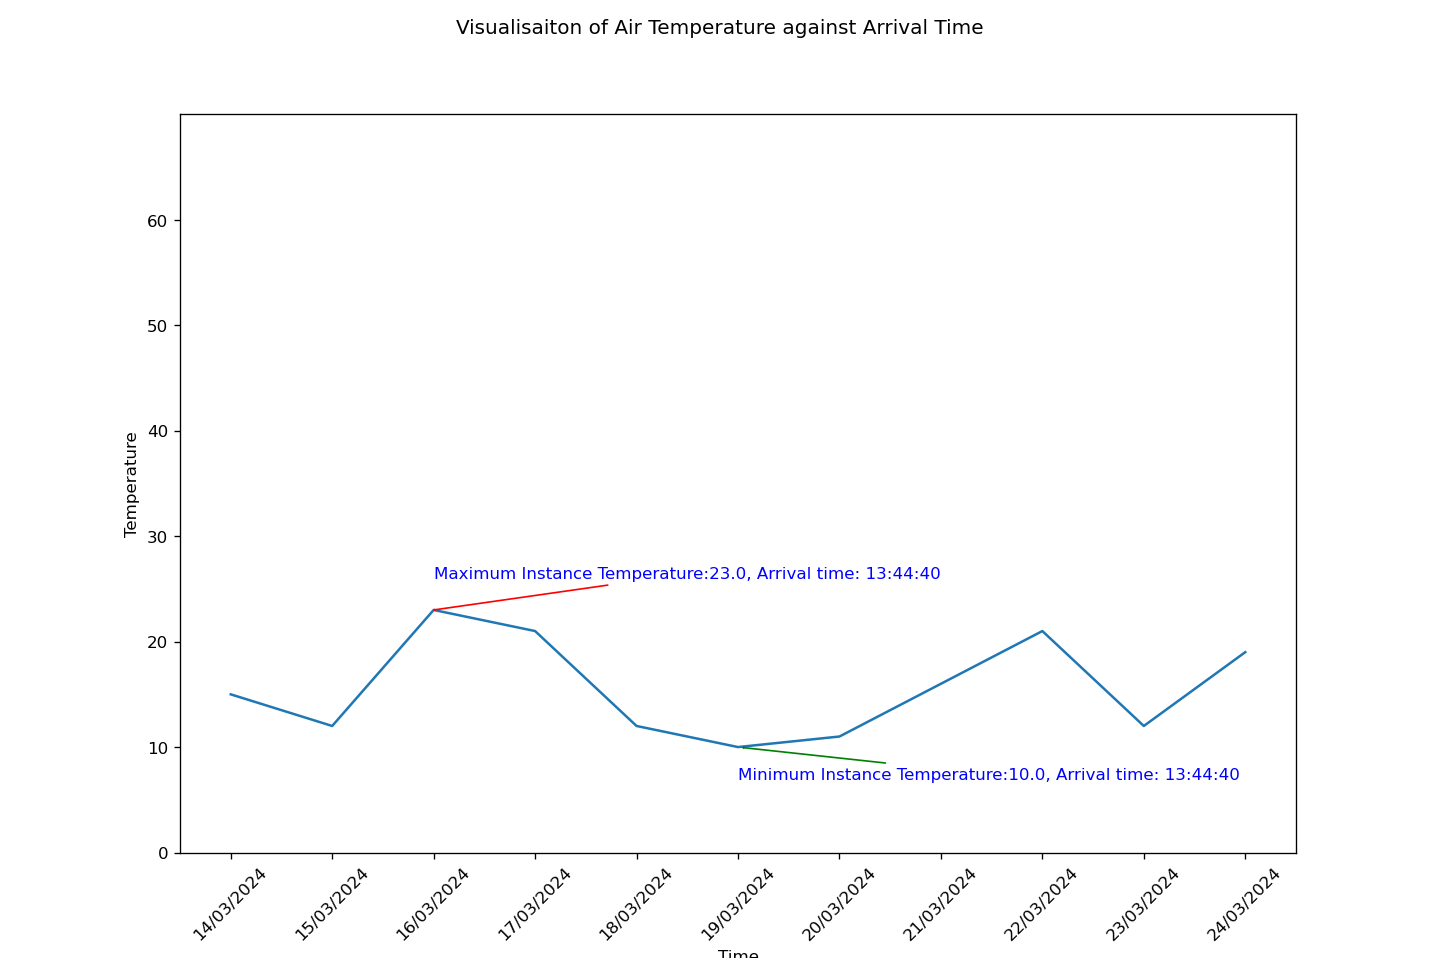

KeyboardInterrupt: 

In [30]:
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax) # consume message

In [8]:
client = MongoClient(host_ip, 27017)  # connect to mongodb
db = client.fit3182
climate_db= db["climate_db"]

In [9]:
result = climate_db.aggregate([{'$unwind': '$hotspot'},
                             {"$project": {
            "hour": { "$hour": { "$toDate": "$hotspot.datetime" } }
        }
    }, {'$group': {
        '_id': '$hour',
        'frequency': {'$sum': 1}}}]) # group and then count the frequency by 1 for each horu
res = []
for doc in result:
    doc['hour'] = doc.pop('_id')
    res.append(doc) #change the id to hour
    
# append both result
hours = [data['hour'] for data in res]
print(hours)

freqs = [data['frequency'] for data in res]
print(freqs)


[0, 3, 12, 13, 1, 9, 4, 11, 5, 23, 15]
[163, 298, 51, 72, 27, 89, 1946, 88, 84, 16, 29]


<IPython.core.display.Javascript object>


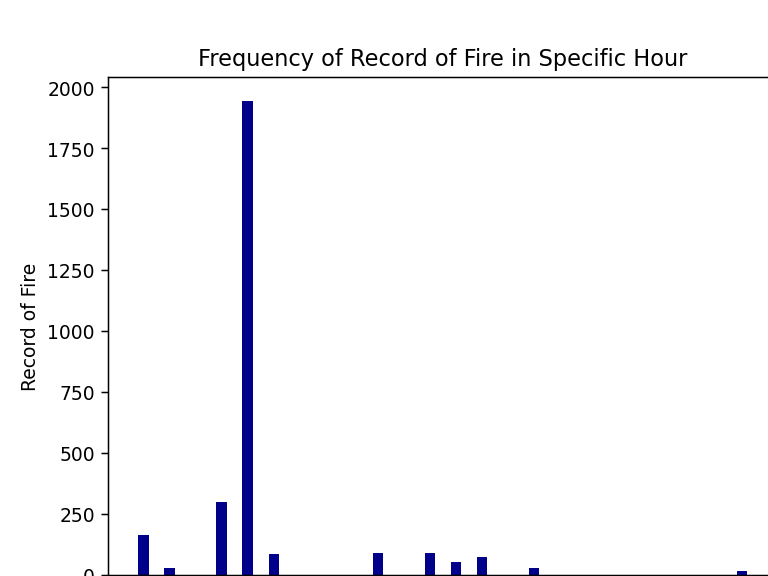

In [10]:
%matplotlib notebook
plt.bar(hours, freqs, color ='darkblue', width = 0.4) #barplot
plt.xlabel("Hour")
plt.ylabel("Record of Fire")
plt.title("Frequency of Record of Fire in Specific Hour")
plt.show()

In [ ]:
#!pip install folium

In [18]:
import folium
fresult = climate_db.aggregate([{'$unwind': '$hotspot'}]) #get all the row that is integrated with each hotspot
res=[]
for row in fresult:
    res.append(row)

In [19]:
longList = []
latList=[]

for row in res:
    #print(row)
    longList.append(float(row['hotspot']['longitude']))
    latList.append(float(row['hotspot']['latitude']))


In [20]:
fomap = folium.Map(location=[max(latList)+min(latList)/2, max(longList)+min(longList)/2], zoom_start=3) 
#initialise the starting position from the midpoitn of lat and long

In [23]:
print(res)

[{'_id': ObjectId('66505beded62c6d69fc531ae'), 'station': '948701', 'date': '6/3/2023', 'air_temperature_celcius': 20.0, 'relative_humidity': 52.9, 'windspeed_knots': 17.0, 'max_wind_speed': 21.0, 'precipitation': '0.00I', 'GHI_w/m2': 167.0, 'hotspot': {'latitude': -34.3795, 'longitude': 141.6331, 'datetime': '2023-03-06 05:06:30', 'confidence': 87.0, 'date': '6/3/2023', 'surface_temperature_celcius': 62.0}}, {'_id': ObjectId('66505beded62c6d69fc531ae'), 'station': '948701', 'date': '6/3/2023', 'air_temperature_celcius': 20.0, 'relative_humidity': 52.9, 'windspeed_knots': 17.0, 'max_wind_speed': 21.0, 'precipitation': '0.00I', 'GHI_w/m2': 167.0, 'hotspot': {'latitude': -34.3735, 'longitude': 141.6604, 'datetime': '2023-03-06 05:06:20', 'confidence': 85.0, 'date': '6/3/2023', 'surface_temperature_celcius': 59.0}}, {'_id': ObjectId('66505beded62c6d69fc531af'), 'station': '948701', 'date': '7/3/2023', 'air_temperature_celcius': 19.0, 'relative_humidity': 51.5, 'windspeed_knots': 10.2, 'ma

In [28]:

for report in res:
    if 'cause' in report['hotspot']: # if cause in dict sicne it is the recent one
        pos=[float(report['hotspot']["latitude"]),float(report['hotspot']["longitude"])] 
        
        air_temp=report["air_temperature_celcius"]
        sur_temp=report['hotspot']["surface_temperature_celcius"]
    
        humidity=report["relative_humidity"]
        confidence=report['hotspot']['confidence']
        causes=report['hotspot']["cause"]
        colors = "blue" if causes=="natural" else "red" # to know what color it is
        formatted_string = "Air temp: {} ,Surface temp: {}, Relative humidity: {}, Confidence: {}".format( sur_temp, air_temp, humidity,confidence)
        folium.Marker(
            location=pos,popup=folium.Popup(formatted_string,max_width=100),
        icon=folium.Icon(color=colors),
        ).add_to(fomap) #add the marker


In [29]:
fomap